In [1]:
!pip install -Uqq fastai

Make sure we have the latest fastai. As of Aug. 2022, it's 2.7.9:

In [2]:
import fastai
fastai.__version__

'2.7.9'

In [3]:
import time
import numpy as np
import pandas as pd
from fastcore.all import *
from fastai.vision.all import *
from fastdownload import download_url

In [4]:
import io
import requests
import matplotlib.pyplot as plt 

In [5]:
def display_image_from_url(url):
    data = requests.get(url).content
    img = fastai.vision.all.Image.open(io.BytesIO(data))
    img = img.to_thumb(256,256)
    plt.imshow(img)
    plt.show()

In [6]:
def gallery(img_paths, max=6, max_cols=3, figsize=(8, 8)):
    img_paths = img_paths[0:max]
    fig = plt.figure(figsize=figsize)
    columns = min(max_cols, len(img_paths))
    rows = len(img_paths) // columns + 1
    for i, path in enumerate(img_paths):
        img = fastai.vision.all.Image.open(path)
        img = img.to_thumb(256,256)
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(img)
    plt.show()

In [7]:
def search_images(term, max_images=200):
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    headers = dict( referer='https://duckduckgo.com/' )
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        res = urlread(requestUrl, data=params, headers=headers)
        data = json.loads(res) if res else {}
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

In [8]:
search_terms = [
    "fantail",
    "kaka",
    "kereru",
    "morepork",
    "tui",
]

In [9]:
searches = {
    term: search_images(term+"+bird+photo", max_images=200)
    for term in search_terms
}

In [10]:
path = Path('bird_classification')
for bird,urls in searches.items():
    print(f"{bird} ({len(urls)})")
    dest = (path/bird)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=urls)
    resize_images(path/bird, max_size=400, dest=path/bird)

fantail (200)
kaka (200)
kereru (200)
morepork (200)
tui (200)


In [11]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

7

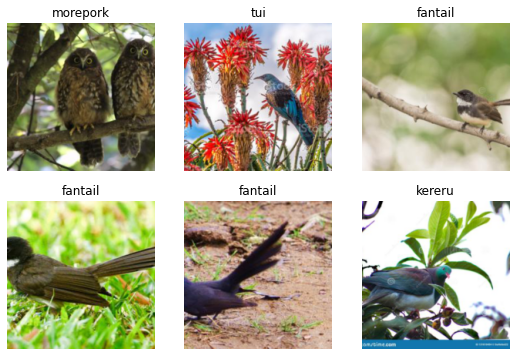

In [12]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='crop')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.653079,0.269318,0.128205,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.361894,0.134377,0.046154,00:05
1,0.255187,0.107556,0.041026,00:05
2,0.181022,0.083570,0.030769,00:04
3,0.132198,0.078908,0.025641,00:04
4,0.099236,0.077554,0.030769,00:04
5,0.079320,0.086495,0.030769,00:04
6,0.061931,0.091932,0.030769,00:04
7,0.050310,0.091150,0.030769,00:05
8,0.042964,0.096737,0.030769,00:05
9,0.035073,0.095272,0.030769,00:05


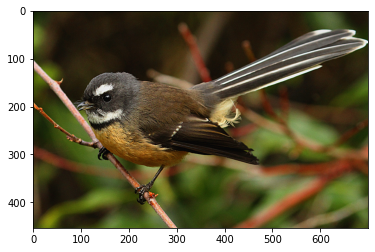

fantail
-------------------------
fantail    0.99999976
kaka       0.00000003
kereru     0.00000001
morepork   0.00000004
tui        0.00000025


In [14]:
url = "https://nzbirdsonline.org.nz/sites/all/files/IMG_0690.JPG"
dest = 'test_image.jpg'
download_url(url, dest, show_progress=true)

img = Image.open(dest)
plt.imshow(img)
plt.show()

pred, _, probs = learn.predict(PILImage.create(dest))
print(pred)
print("-"*25)
for name,p in zip(search_terms, probs):
    print(f"{name:10} {p:0.08f}")

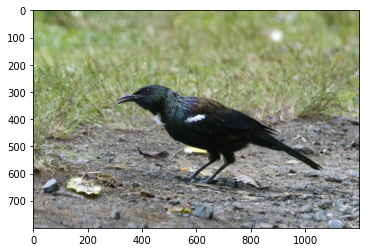

tui
-------------------------
fantail    0.00008230
kaka       0.00076591
kereru     0.00000399
morepork   0.00000603
tui        0.99914169


In [15]:
url = "https://nzbirdsonline.org.nz/sites/all/files/1200543IMG_0709nzbo.jpg"
dest = 'test_image.jpg'
download_url(url, dest, show_progress=true)

img = Image.open(dest)
plt.imshow(img)
plt.show()

pred, _, probs = learn.predict(PILImage.create(dest))
print(pred)
print("-"*25)
for name,p in zip(search_terms, probs):
    print(f"{name:10} {p:0.08f}")

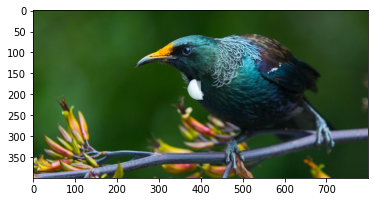

tui
-------------------------
fantail    0.00000110
kaka       0.00002631
kereru     0.00001332
morepork   0.00000007
tui        0.99995923


In [16]:
url = "https://www.visitzealandia.com/portals/0/Images/Birds/Tui-Chris-Helliwell.jpg"
dest = 'test_image.jpg'
download_url(url, dest, show_progress=true)

img = Image.open(dest)
plt.imshow(img)
plt.show()

pred, _, probs = learn.predict(PILImage.create(dest))
print(pred)
print("-"*25)
for name,p in zip(search_terms, probs):
    print(f"{name:10} {p:0.08f}")

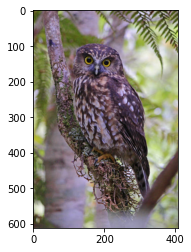

morepork
-------------------------
fantail    0.00000000
kaka       0.00000294
kereru     0.00000116
morepork   0.99999583
tui        0.00000011


In [17]:
url="https://media.istockphoto.com/photos/morepork-west-coast-picture-id1050662486?k=20&m=1050662486&s=612x612&w=0&h=MOVn6keg2nddr4u5XjK02zkFcir3fjZUiD7FQW1JcG0="
dest = 'test_image.jpg'
download_url(url, dest, show_progress=true)

img = Image.open(dest)
plt.imshow(img)
plt.show()

pred, _, probs = learn.predict(PILImage.create(dest))
print(pred)
print("-"*25)
for name,p in zip(search_terms, probs):
    print(f"{name:10} {p:0.08f}")

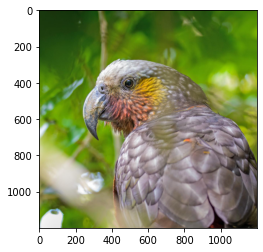

kaka
-------------------------
fantail    0.00000113
kaka       0.99995947
kereru     0.00000349
morepork   0.00003592
tui        0.00000009


In [18]:
url="https://nzbirdsonline.org.nz/sites/all/files/1200469Kaka%2CDunedin%2C090218%2C-27webnz.jpg"
dest = 'test_image.jpg'
download_url(url, dest, show_progress=true)

img = Image.open(dest)
plt.imshow(img)
plt.show()

pred, _, probs = learn.predict(PILImage.create(dest))
print(pred)
print("-"*25)
for name,p in zip(search_terms, probs):
    print(f"{name:10} {p:0.08f}")

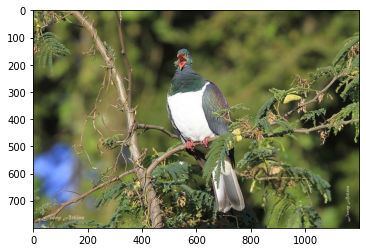

kereru
-------------------------
fantail    0.00000493
kaka       0.00000001
kereru     0.99999332
morepork   0.00000001
tui        0.00000175


In [19]:
url="https://nzbirdsonline.org.nz/sites/all/files/1200466_MG_5794.JPG"
dest = 'test_image.jpg'
download_url(url, dest, show_progress=true)

img = Image.open(dest)
plt.imshow(img)
plt.show()

pred, _, probs = learn.predict(PILImage.create(dest))
print(pred)
print("-"*25)
for name,p in zip(search_terms, probs):
    print(f"{name:10} {p:0.08f}")

In [20]:
learn.save("nz-bird-model-resnet18")

Path('models/nz-bird-model-resnet18.pth')

In [21]:
!ls -alph models/

total 135M
drwxr-xr-x 2 root root 4.0K Aug 27 05:01 ./
drwxr-xr-x 4 root root 4.0K Aug 27 05:01 ../
-rw-r--r-- 1 root root 135M Aug 27 05:01 nz-bird-model-resnet18.pth
